# Hair Segmentation 

In [83]:
import os
import numpy as np
import torch
import torch.utils.data as td
from PIL import Image
import matplotlib.pyplot as plt
import math
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
collab = False
import cv2
plt.rcParams['image.cmap'] = 'gray'

cuda


In [84]:
# a = torch.rand(4,4)
# print(a.cuda())

## Import dataset

In [85]:
# Dataset class
class HairDataset(td.Dataset):
    
    #mode should be 'Training' or 'Testing'
    def __init__(self, img_dir, gt_dir, mode='Training', image_size=(128, 128)):
        super(HairDataset, self).__init__()
        self.mode = mode
        self.image_size = image_size
        self.images_dir = os.path.join(img_dir, mode)
        self.images = sorted(os.listdir(self.images_dir))
        self.targets_dir = os.path.join(gt_dir, mode)
        self.targets = sorted(os.listdir(self.targets_dir))        
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.images[idx])    
        img = np.asarray(Image.open(img_path).resize(self.image_size).convert('L'))/255
        target_path = os.path.join(self.targets_dir, self.targets[idx])    
        target = np.asarray(Image.open(target_path).resize(self.image_size).convert('L'))/255
        return img, target

Nombre d'images dans le training set : 840
Nombre d'images dans le testing set : 210


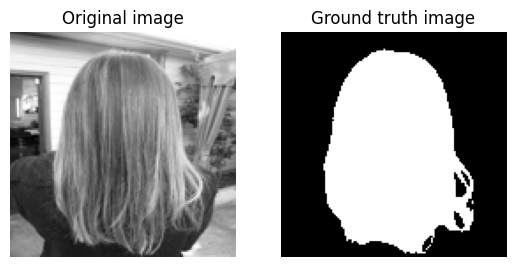

In [86]:
# define dataset dir path
if collab is False:
    root_dir = ''
else :
    root_dir = '/'
    !unzip /Figaro1k.zip -d /


img_dir = os.path.join(root_dir, 'Figaro1k/Original')
gt_dir = os.path.join(root_dir, 'Figaro1k/GT')


# build training and testing set
train_set =  HairDataset(img_dir=img_dir, gt_dir=gt_dir, mode='Training')
test_set =  HairDataset(img_dir=img_dir, gt_dir=gt_dir, mode='Testing')
print("Nombre d'images dans le training set :", len(train_set))
print("Nombre d'images dans le testing set :", len(test_set))

# Seperate orignals and ground truth
def image_mask_separator(dataset):
    X = []
    y = []
    for image, mask in dataset:
        X.append(image)
        y.append(mask)
    return np.array(X), np.array(y)

X_train, y_train = image_mask_separator(train_set)
X_test, y_test = image_mask_separator(test_set)

# histogram equalization
def histogram_equalization(images):
    X = []
    for image in images:
        image = np.uint8(image)
        image = cv2.equalizeHist(image)
        X.append(image)
    return np.array(X)

# apply histogram equalization
# X_train = histogram_equalization(X_train)
# X_test = histogram_equalization(X_test)
# plt.imshow(X_train[5])

# data augmentation
def data_augmentation(images, masks):
    X = []
    y = []
    for image, mask in zip(images, masks):
        X.append(image)
        y.append(mask)
        X.append(np.fliplr(image))
        y.append(np.fliplr(mask))
        X.append(np.rot90(image))
        y.append(np.rot90(mask))
    return np.array(X), np.array(y)

X_train, y_train = data_augmentation(X_train, y_train)
X_test, y_test = data_augmentation(X_test, y_test)

#permutation x_train et y_train
permutation = np.random.permutation(X_train.shape[0])
X_train = X_train[permutation]
y_train = y_train[permutation]

# visualize images
def visualize_data(images, axes):
    img, target = images[0], images[1]
    axes[0].imshow(img)
    axes[0].set_title('Original image')
    axes[0].axis('off')
    axes[1].imshow(target)
    axes[1].set_title('Ground truth image')
    axes[1].axis('off')

fig, axes = plt.subplots(ncols=2)
visualize_data(train_set[5], axes)


(128, 128)


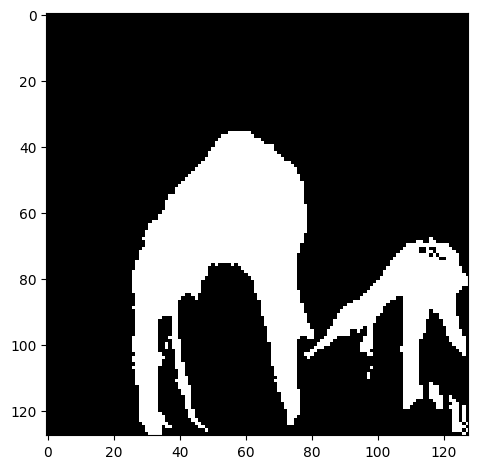

In [87]:
y = (y_train[0] * 255.)

print(y.shape)
plt.imshow(y)
plt.tight_layout()

## Create CNN

In [88]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, concatenate, BatchNormalization, Dropout
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau
from keras.losses import BinaryCrossentropy


In [89]:
# Architecture from https://www.kaggle.com/code/rahuldshetty/hair-segmentation-using-u-net/notebook
inputs = Input((128, 128, 1))
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
pool1 = Dropout(0.2)(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
pool2 = Dropout(0.2)(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
pool3 = Dropout(0.2)(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
pool4 = Dropout(0.2)(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
# poo5a = MaxPooling2D(pool_size=(2, 2))(conv5)
# conv5a = Conv2D(1024, (3, 3), activation='relu', padding='same')(poo5a)
# conv5a = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5a)

In [90]:
# up6a = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5a), conv5], axis=3)
# conv6a = Conv2D(512, (3, 3), activation='relu', padding='same')(up6a)
# conv6a = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6a)
up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3) #Was conv5 instead of conv6a
up6 = Dropout(0.2)(up6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
up7 = Dropout(0.2)(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
up8 = Dropout(0.2)(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
up8 = Dropout(0.2)(up8)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
conv10 = Conv2D(1, (3, 3), activation='relu', padding='same')(conv9)

model = Model(inputs=[inputs], outputs=[conv10])
model.compile(optimizer='adam', loss=BinaryCrossentropy(), metrics=['acc'])
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_126 (Conv2D)            (None, 128, 128, 32  320         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_127 (Conv2D)            (None, 128, 128, 32  9248        ['conv2d_126[0][0]']             
                                )                                                           

## Train NN

In [91]:
#Create directory to save model and history
num_train = 0
while os.path.isdir(os.path.join(root_dir, 'training_{i}'.format(i=num_train))):
    num_train +=1
save_dir = os.path.join(root_dir, 'training_{i}'.format(i=num_train))
os.makedirs(save_dir)

#train model
epochs = 150
history = model.fit(X_train,y_train,validation_split=0.15,epochs=epochs,batch_size=128,)
model.save(os.path.join(save_dir, 'model.h5'))
np.save(os.path.join(save_dir, 'my_history.npy') ,history)
    

Epoch 1/150
17/17 [==============================] - 9s 482ms/step - loss: 1.5681 - acc: 0.5926 - val_loss: 0.7647 - val_acc: 0.6088
Epoch 2/150
17/17 [==============================] - 8s 464ms/step - loss: 0.7335 - acc: 0.6201 - val_loss: 0.7076 - val_acc: 0.6369
Epoch 3/150
17/17 [==============================] - 8s 464ms/step - loss: 0.6646 - acc: 0.6570 - val_loss: 0.7523 - val_acc: 0.6588
Epoch 4/150
17/17 [==============================] - 8s 463ms/step - loss: 0.6466 - acc: 0.6557 - val_loss: 0.6268 - val_acc: 0.6588
Epoch 5/150
17/17 [==============================] - 8s 464ms/step - loss: 0.6207 - acc: 0.6582 - val_loss: 0.6105 - val_acc: 0.6588
Epoch 6/150
17/17 [==============================] - 8s 463ms/step - loss: 0.6098 - acc: 0.6577 - val_loss: 0.6007 - val_acc: 0.6596
Epoch 7/150
17/17 [==============================] - 8s 467ms/step - loss: 0.6075 - acc: 0.6570 - val_loss: 0.6044 - val_acc: 0.6588
Epoch 8/150
17/17 [==============================] - 8s 465ms/step - 

INFO:tensorflow:Assets written to: ram://a5c0d630-2c9f-4c95-ba01-8f01b1be35cd/assets


INFO:tensorflow:Assets written to: ram://a5c0d630-2c9f-4c95-ba01-8f01b1be35cd/assets


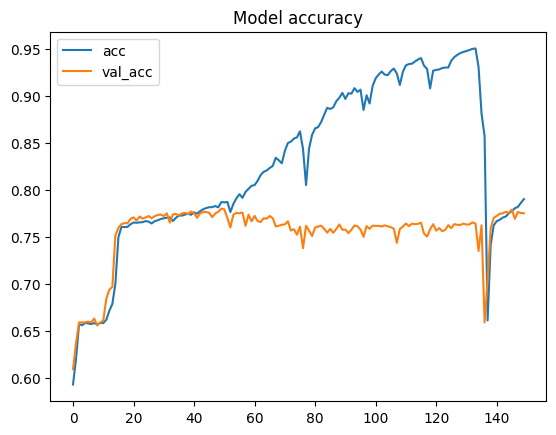

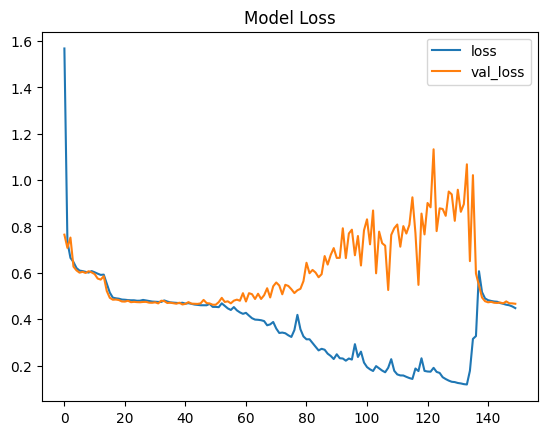

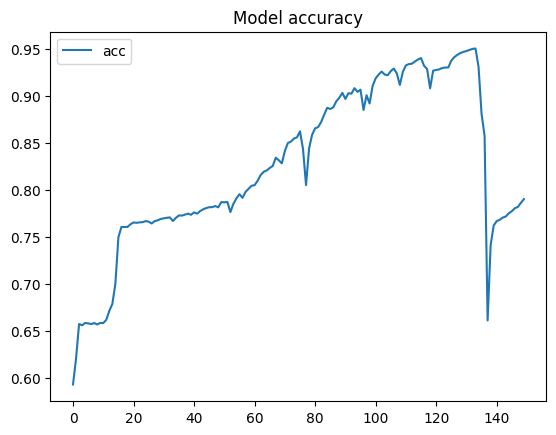

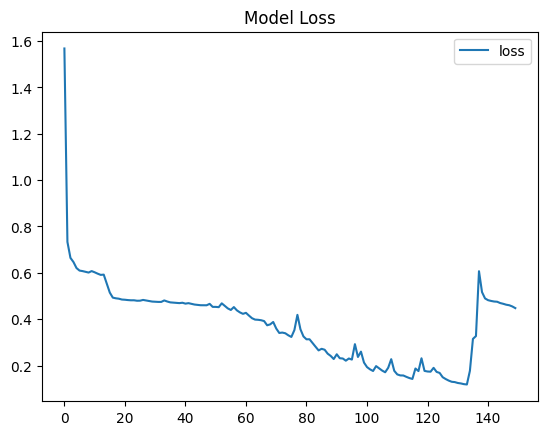

In [97]:
#history=np.load('training_5/my_history.npy',allow_pickle='TRUE').item()
#history=np.load('training_grayscale_small/my_history.npy',allow_pickle='TRUE').item()
# Must have been training during this execution
h = history
plt.plot(h.history['acc'], label='acc')
plt.plot(h.history['val_acc'], label='val_acc')
plt.title('Model accuracy')
plt.legend()
plt.show()

plt.plot(h.history['loss'], label='loss')
plt.plot(h.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.legend()
plt.show()

plt.plot(h.history['acc'], label='acc')
plt.title('Model accuracy')
plt.legend()
plt.show()

plt.plot(h.history['loss'], label='loss')
plt.legend()
plt.title('Model Loss')
plt.show()

## Predict single image

(630, 128, 128)
(128, 128)
1/1 [==============================] - 0s 167ms/step
(1, 128, 128, 1)
(128, 128, 1)
(128, 128)
1/1 [==============================] - 0s 200ms/step - loss: 0.3145 - acc: 0.8899
accuacy :  0.889892578125


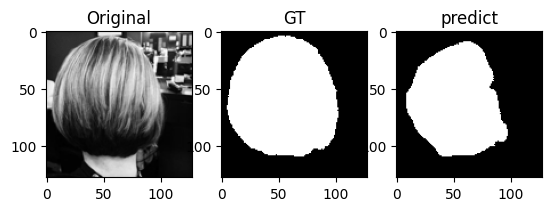

In [98]:
#Load trained model if necessary
model = load_model('training_5/model.h5')
#model = load_model('training_grayscale_small/model.h5')
idx = 30

print(X_test.shape)
print(X_test[idx].shape)

pred = model.predict(X_test[idx][np.newaxis,:,:])

treshold = 0.5
print(pred.shape)

#Get predicted masks
pred_mask = ((pred > treshold) * 255.)
print(pred_mask[0].shape)

fig, axes = plt.subplots(nrows=1, ncols=3)
plt.subplot(1,3,1)
plt.imshow(X_test[idx])
plt.title("Original")
plt.subplot(1,3,2)
print(y_test[idx].shape)
plt.imshow(y_test[idx])
plt.title("GT")
plt.subplot(1,3,3)
plt.imshow(pred_mask[0])
plt.title("predict")

score = model.evaluate(X_test[idx][np.newaxis,:,:], y_test[idx][np.newaxis,:,:])
print("accuacy : ", score[1])

## Predict n first images

20/20 [==============================] - 1s 38ms/step


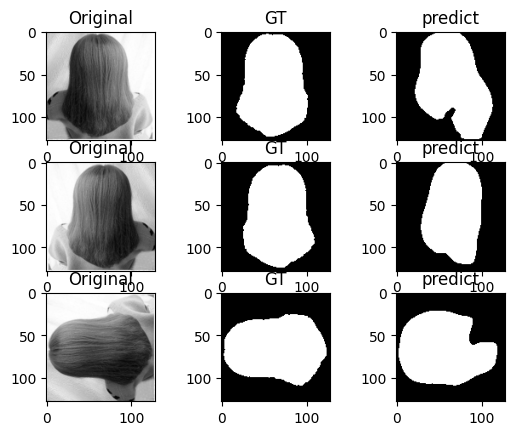

In [95]:
#Load trained model if necessary
model = load_model('training_grayscale/model.h5')
#model = load_model('training_grayscale_small/model.h5')
n = 3
treshold = 0.5

pred = model.predict(X_test)
#Get predicted masks
pred_mask = ((pred > treshold) * 255.)

fig, axes = plt.subplots(nrows=n, ncols=3)
for i in range(n*3):
    plt.subplot(3,3,i+1)
    if i % 3 == 0:
        plt.imshow(X_test[i//3])
        plt.title("Original")
    elif i % 3 == 1:
        plt.imshow(y_test[i//3])
        plt.title("GT")
    else:
        plt.imshow(pred_mask[i//3])
        plt.title("predict")

In [96]:
#Evaluate model

score_train = model.evaluate(X_train, y_train)
score_test = model.evaluate(X_test, y_test)

print("accuracy on training set :", score_train[1])
print("accuracy on testing set :", score_test[1])

20/20 [==============================] - 1s 37ms/step - loss: 1.0055 - acc: 0.7740
accuracy on training set : 0.9299465417861938
accuracy on testing set : 0.773963451385498
